In [1]:
import sys
import os
import random
import gc
import time
import torch
import numpy as np
import pandas as pd
import pickle
import ast
from tqdm import tqdm
from scipy.sparse import csr_matrix
import itertools
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator
import nltk
nltk.download('punkt')
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG import *
from SHapRAG.utils import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df=pd.read_json("../data/musique/musique_ans_v1.0_train.jsonl", lines=True)

In [3]:
def get_titles(lst):
    # Titles where is_supporting is True
    supporting = [d['paragraph_text'] for d in lst if d.get('is_supporting') == True]
    # Titles where is_supporting is False or missing AND not already in supporting
    others = [d['paragraph_text'] for d in lst if d.get('is_supporting') != True and d['paragraph_text'] not in supporting]
    # Combine: all supporting + as many others as needed to reach 10
    result = supporting + others
    return result[:10]

df.paragraphs=df.paragraphs.apply(get_titles)

In [ ]:
# df['Sentences'] = df['paragraphs'].apply(
#     lambda para_list: [sent for para in para_list for sent in nltk.sent_tokenize(para)]
# )

In [ ]:
# df_save=pd.read_csv('../data/musique/sen_labeled.csv',
#     quotechar='"',
#     skipinitialspace=True,
#     engine='python' )

In [4]:
df["paragraphs"] = df["paragraphs"].apply(lambda p: p[:5]+ [p[1]] + p[5:])

In [5]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
# model_path = "mistralai/Mistral-7B-Instruct-v0.3"
model_path = "meta-llama/Llama-3.1-8B-Instruct"
# model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Main Script: Loading model...


2025-10-20 09:59:52.887106: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 09:59:52.929575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-20 09:59:54.308336: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [6]:
with open("answered.txt", "r") as f:
    res = [line.strip() for line in f]

In [7]:
def gtset_k():
    return [0, 1,5]

num_questions_to_run = 50
k_values = [1, 2, 3, 4, 5]
all_results = []
extras = []

for i in tqdm(range(num_questions_to_run), disable=not accelerator_main.is_main_process):
    query = df.question[i]
    if res[i]=="True":
        if accelerator_main.is_main_process:
            print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

        docs = df.paragraphs[i]
        utility_cache_base_dir = f"../Experiment_data/musique/{model_path.split('/')[1]}/new/duplicate"
        utility_cache_filename = f"utilities_q_idx{i}.pkl"
        current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)

        if accelerator_main.is_main_process:
            os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)

        harness = ContextAttribution(
            items=docs,
            query=query,
            prepared_model=prepared_model,
            prepared_tokenizer=tokenizer,
            accelerator=accelerator_main,
            utility_cache_path=current_utility_path
        )
        full_budget=pow(2,harness.n_items)
        # res = evaluate(df.question[i], harness.target_response, df.answer[i])
        # res='True'
        if accelerator_main.is_main_process:
            methods_results = {}
            metrics_results = {}
            extra_results = {}

            m_samples_map = {"XS": 32, "S":64, "M":128, "L":264, "XL":528, "XXL":724, "XXXL":1024}

            # Store FM models for later R²/MSE
            fm_models = {}
            methods_results['Exact-Shap']=harness._calculate_shapley()
            for size_key, actual_samples in m_samples_map.items():

                methods_results[f"ContextCite_{actual_samples}"], fm_models[f"ContextCite_{actual_samples}"] = harness.compute_contextcite(
                    num_samples=actual_samples, seed=SEED
                )
                # FM Weights (loop over ranks 0–5)
                # for rank in range(5, -1, -1):
                    # methods_results[f"FM_WeightsLK_{rank}_{actual_samples}"], extra_results[f"Flk_{rank}_{actual_samples}"], fm_models[f"FM_WeightsLK_{rank}_{actual_samples}"] = harness.compute_wss(
                    #     num_samples=actual_samples,
                    #     seed=SEED,
                    #     sampling="kernelshap",
                    #     sur_type="fm",
                    #     rank=rank
                    # )
                    # methods_results[f"FM_WeightsLU_{rank}_{actual_samples}"], extra_results[f"Flu_{rank}_{actual_samples}"], fm_models[f"FM_WeightsLU_{rank}_{actual_samples}"] = harness.compute_wss(
                    #     num_samples=actual_samples,
                    #     seed=SEED,
                    #     sampling="kernelshap",
                    #     sur_type="fm",
                    #     rank=rank
                    # )
                # methods_results[f"FM_u_dynamic_{actual_samples}"], extra_results[f"FM_u_dynamic_{actual_samples}"], fm_models[f"FM_u_dynamic_{actual_samples}"] = harness.compute_wss_dynamic_pruning_reuse_utility(num_samples=actual_samples)
                methods_results[f"FM_k_dynamic_{actual_samples}"], extra_results[f"FM_k_dynamic_{actual_samples}"], fm_models[f"FM_k_dynamic_{actual_samples}"] = harness.compute_wss_dynamic_pruning_reuse_utility(num_samples=actual_samples)
                # methods_results[f"FM_k_dynamice_{actual_samples}"], extra_results[f"FM_k_dynamice_{actual_samples}"], fm_models[f"FM_k_dynamice_{actual_samples}"] = harness.compute_wss_dynamic_pruning_reuse_utility(num_samples=actual_samples, pruning_strategy='elbow')
                try:
                    # attributionsspex, interactionspex = harness.compute_spex(sample_budget=actual_samples, max_order=2)
                    attributionshap, interactionshap, fm_models[f"FSII_{actual_samples}"] = harness.compute_fsii(sample_budget=actual_samples, max_order=harness.n_items)
                    attributionban, interactionban, fm_models[f"FBII_{actual_samples}"] = harness.compute_fbii(sample_budget=actual_samples, max_order=harness.n_items)
                    methods_results[f"FBII_{actual_samples}"] = attributionban
                    # methods_results[f"Spex_{actual_samples}"] = attributionsspex
                    methods_results[f"FSII_{actual_samples}"] = attributionshap

                    extra_results.update({
                    f"Int_FSII_{actual_samples}":interactionshap,
                    f"Int_FBII_{actual_samples}":interactionban,
                    # f"Int_Spex_{actual_samples}":interactionspex
                                                                            })
                except Exception: pass


            methods_results["LOO"] = harness.compute_loo()
            methods_results["ARC-JSD"] = harness.compute_arc_jsd()
            attributionxs, interactionxs, fm_models["Exact-FSII"] = harness.compute_exact_fsii(max_order=2)

            extra_results.update({
            "Exact-FSII": interactionxs
        })
            methods_results["Exact-FSII"]=attributionxs

            # --- Evaluation Metrics ---
            metrics_results["topk_probability"] = harness.evaluate_topk_performance(
                methods_results, fm_models, k_values
            )

            # R²
            metrics_results["R2"] = harness.r2(methods_results,100,mode='logit-prob', models=fm_models)
            metrics_results['Recall']=harness.recall_at_k(gtset_k(), methods_results, k_values)

            # LDS per method
            metrics_results["LDS"] = harness.lds(methods_results,100,mode='logit-prob', models=fm_models)



            all_results.append({
                "query_index": i,
                "query": query,
                "ground_truth": df.answer[i],
                "response": harness.target_response,
                "methods": methods_results,
                "metrics": metrics_results
            })
            extras.append(extra_results)

            # Save utility cache
            harness.save_utility_cache(current_utility_path)
# with open(f"{utility_cache_base_dir}/results.pkl", "wb") as f:
#     pickle.dump(all_results, f)

# with open(f"{utility_cache_base_dir}/extras.pkl", "wb") as f:
#     pickle.dump(extras, f)

  0%|          | 0/50 [00:00<?, ?it/s]


--- Question 2/50: What year saw the creation of the region where the county of... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx1.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 301612.87it/s]


Initial scores: [0.3331031  2.41925089 0.90044644 1.42011335 1.15696147 3.99287411
 1.04108284 1.40782769 0.06135233 0.12033873 0.21192064]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 104980.62it/s]


Initial scores: [0.44176151 7.30603996 1.34139166 0.70147645 0.96409159 4.55982854
 0.         0.05449621 0.6419876  1.06966699 0.78498281]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 372827.02it/s]


Initial scores: [0.02831215 5.35368474 0.8491232  0.24333942 0.13965413 5.8441686
 0.58958593 0.14569124 0.45644827 0.37122158 0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 479556.63it/s]


Initial scores: [0.7180572  6.16704111 0.27599132 0.31857983 0.23398967 5.81136221
 0.         0.67503673 0.76027808 0.         0.69967402]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 323676.19it/s]


Initial scores: [0.25931239 5.78144035 0.25005718 0.27006384 0.06501163 5.9580828
 0.17634335 0.08272292 0.21783301 0.24273346 0.37970278]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 525922.43it/s]


Initial scores: [0.13656555 5.73571137 0.         0.11883026 0.         6.04894463
 0.         0.31866579 0.17268576 0.36854789 0.32619776]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 395375.80it/s]


Initial scores: [0.         6.0294555  0.05324332 0.3649113  0.02676653 5.98865978
 0.01303615 0.04022169 0.44346426 0.03587012 0.25257134]
We are keeping 7 documents


  4%|▍         | 2/50 [00:28<11:15, 14.06s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx1.pkl...
Save complete.

--- Question 3/50: When was the abolishment of the studio that distributed The ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx2.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 339791.72it/s]


Initial scores: [15.49186649  0.382738    0.26714348  0.29928291  0.62694484  0.07389377
  0.5183342   0.08521315  0.07818419  0.          0.31422331]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 446648.01it/s]


Initial scores: [14.60274883  1.81723803  0.071401    0.06679817  0.54089425  1.22916853
  0.04539781  0.07744957  0.          0.17006414  0.52153838]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 537946.81it/s]


Initial scores: [15.4384802   1.47515498  0.30790962  0.          0.          1.21239618
  0.20678804  0.0311451   0.07518798  0.28946012  0.29955803]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 608404.54it/s]


Initial scores: [1.57405961e+01 9.81655370e-01 7.28362313e-02 0.00000000e+00
 7.87401243e-03 6.42930529e-01 1.85177881e-02 0.00000000e+00
 1.19825378e-01 1.11553903e-02 1.88733261e-02]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 436803.26it/s]


Initial scores: [15.70576286  0.89683047  0.14211771  0.          0.          0.82833475
  0.13086484  0.03211513  0.          0.          0.27611174]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 403384.18it/s]


Initial scores: [1.57532944e+01 9.10435909e-01 2.21569856e-01 1.83264234e-03
 0.00000000e+00 8.62654571e-01 1.02410792e-01 2.09138499e-02
 4.58219620e-02 5.34643031e-02 2.88091915e-01]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 425623.56it/s]


Initial scores: [1.57390873e+01 9.10598366e-01 1.57120214e-01 3.58172127e-02
 0.00000000e+00 8.80093571e-01 9.43669757e-02 3.62171966e-02
 3.20906279e-03 0.00000000e+00 2.64670269e-01]
We are keeping 7 documents


  6%|▌         | 3/50 [00:38<09:46, 12.48s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx2.pkl...
Save complete.

--- Question 5/50: Jan Šindel's was born in what country?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx4.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 276168.16it/s]


Initial scores: [6.84721244 1.95408747 1.82347273 0.99072761 0.         2.35153585
 0.2567308  0.         0.03906991 0.26532758 1.61130462]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 337654.66it/s]


Initial scores: [7.77687103 3.17103805 0.15695804 0.36469629 0.58018133 1.81098728
 0.64409367 0.0157929  0.30530715 0.34602132 0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 365218.31it/s]


Initial scores: [7.25081665 2.25951694 0.97483644 0.42137084 0.         2.30745498
 0.27220117 0.34152325 0.09772054 0.0150241  0.34247597]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 444518.77it/s]


Initial scores: [7.74569356e+00 2.15617579e+00 1.11287844e+00 2.99557415e-01
 1.59576841e-01 2.30035158e+00 8.09352860e-02 0.00000000e+00
 1.25753253e-01 2.37554747e-01 3.14618913e-03]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 478934.37it/s]


Initial scores: [7.87246486 1.98652551 0.9337335  0.56435461 0.07727981 2.11486562
 0.26215605 0.28851262 0.32069467 0.22374866 0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 576985.77it/s]


Initial scores: [7.6673037  1.93269428 1.10132095 0.47958687 0.         2.25372597
 0.10814608 0.04351891 0.30729401 0.16872445 0.01450083]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 522247.97it/s]


Initial scores: [7.61345969 2.03148873 0.94766588 0.40381481 0.03052357 2.07486863
 0.05698524 0.20673375 0.24302913 0.17773681 0.08539233]
We are keeping 7 documents


 10%|█         | 5/50 [00:47<06:10,  8.24s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx4.pkl...
Save complete.

--- Question 6/50: What city is the person who broadened the doctrine of philos... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx5.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 316551.25it/s]


Initial scores: [4.91746336 2.75458353 1.06554659 2.34409339 1.41453627 4.75066597
 0.24610802 0.87200019 1.09901241 0.17083527 1.45758824]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 400052.84it/s]


Initial scores: [6.27952163 4.53997864 0.01089248 0.39469186 0.57674798 3.43317152
 0.19389687 0.15155127 2.42827831 0.40805869 0.51178668]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 492090.66it/s]


Initial scores: [5.34174414 3.07706654 0.41918227 0.17592565 0.47911224 4.10803103
 0.43690047 0.19090073 1.43264976 0.45610538 0.50274027]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 610753.59it/s]


Initial scores: [5.59341579 3.99652017 0.8463845  0.19303122 0.31950327 3.80741047
 0.12254512 0.07743848 2.09699043 0.62065305 0.04123303]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 612612.04it/s]


Initial scores: [5.70356915e+00 3.57889376e+00 5.87036534e-01 2.27043371e-01
 0.00000000e+00 3.77949745e+00 1.59149726e-01 3.91190368e-05
 2.27648534e+00 2.64025042e-01 3.31881509e-01]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 592637.80it/s]


Initial scores: [5.48571308 3.43587686 0.71333959 0.40198408 0.         3.62449115
 0.13918953 0.09525721 1.94709918 0.20334466 0.01634815]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 601451.80it/s]


Initial scores: [5.37388412e+00 3.35271084e+00 6.44750088e-01 2.83179591e-01
 7.83890250e-02 3.49093628e+00 1.76468185e-01 2.26867999e-01
 2.03576310e+00 2.09068932e-01 3.06392418e-03]
We are keeping 7 documents


 12%|█▏        | 6/50 [00:58<06:34,  8.96s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx5.pkl...
Save complete.

--- Question 7/50: When was the baseball team winning the world series in 2015 ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx6.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 339791.72it/s]


Initial scores: [12.475839    1.06177916  0.44671811  0.          0.65185261  0.39876357
  1.00231349  0.          0.5071847   0.49472195  0.15024255]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 326167.02it/s]


Initial scores: [12.91620101  0.82161098  0.24373192  0.17495806  0.19703419  0.01492457
  0.428798    0.08112867  0.07633571  0.20100629  0.04623066]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 458472.17it/s]


Initial scores: [1.25579143e+01 6.23551892e-02 4.03507252e-03 2.40946059e-01
 3.58723789e-01 3.30392706e-01 9.02716735e-02 8.33497367e-02
 1.15708743e-01 5.50179970e-03 1.01430585e-01]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 558394.48it/s]


Initial scores: [12.46333859  0.28408661  0.21678671  0.1503656   0.0952868   0.42011485
  0.48407383  0.          0.          0.10343497  0.03747967]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 590558.00it/s]


Initial scores: [12.64727322  0.36696803  0.32204472  0.1113284   0.33866598  0.37905392
  0.44726431  0.          0.13636166  0.0172518   0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 463614.67it/s]


Initial scores: [1.26126215e+01 3.01361061e-01 2.70321855e-01 8.04257748e-02
 1.46024620e-01 3.33752808e-01 4.66265829e-01 7.44002147e-02
 3.27301581e-02 9.22140291e-03 5.46385872e-02]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 567366.88it/s]


Initial scores: [1.26671092e+01 2.98044169e-01 2.97752468e-01 1.05931496e-01
 1.94952171e-01 1.90643303e-01 4.35770347e-01 3.24688043e-02
 2.91371919e-02 8.83310228e-03 0.00000000e+00]
We are keeping 7 documents


 14%|█▍        | 7/50 [01:10<07:01,  9.81s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx6.pkl...
Save complete.

--- Question 9/50: Who was thee first president of the association that wrote t... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx8.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 327360.31it/s]


Initial scores: [14.02924753  0.45645601  0.          0.99442367  0.51082854  1.09119737
  0.72865264  2.66361603  0.80363168  0.36975052  0.81518142]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 420086.79it/s]


Initial scores: [12.77482401  0.16005322  0.42299744  0.69515159  0.47045754  0.2176211
  1.60952092  0.          0.31301945  1.15845021  0.27462747]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 519720.15it/s]


Initial scores: [12.73515774  0.17028954  0.98678912  0.61387452  0.3660284   0.04013607
  1.11215115  0.42934052  0.91227041  0.08524072  0.02976393]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 589614.62it/s]


Initial scores: [13.27728605  1.0676788   0.17816361  0.28501369  0.56599594  0.41801899
  0.70086298  0.35975695  0.35734565  0.55111425  0.47745989]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 590715.53it/s]


Initial scores: [13.58842352  0.86826514  0.30108509  0.37954322  0.11672348  0.5406777
  0.34055047  0.48949278  0.17280713  0.47274181  0.60920588]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 577864.15it/s]


Initial scores: [13.61279584  0.78165554  0.15098595  0.44229647  0.1456027   0.48357589
  0.39835012  0.55793923  0.27734428  0.23600017  0.44331953]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 586984.73it/s]


Initial scores: [13.78597623  0.73593933  0.14042194  0.30909616  0.0760413   0.46289023
  0.30498255  0.56690655  0.22738274  0.27230117  0.30379782]
We are keeping 7 documents


 18%|█▊        | 9/50 [01:19<05:06,  7.49s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx8.pkl...
Save complete.

--- Question 10/50: Which major Russian city borders the body of water in which ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx9.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 335544.32it/s]


Initial scores: [7.44166748 2.91742121 4.23323917 0.27347547 2.2953034  1.83614282
 1.05885048 0.73478617 0.54623536 0.34423881 0.49698849]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 444429.56it/s]


Initial scores: [5.99972545 3.51847404 1.74882877 0.6607194  0.07874251 0.02805372
 0.83338033 1.17252327 1.36654875 0.20581972 1.06088964]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 525314.00it/s]


Initial scores: [5.6481304  3.19259214 3.24822536 0.2120321  0.24199224 0.37582989
 0.20165866 0.29840606 1.27627499 1.05763357 0.01449247]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 580039.95it/s]


Initial scores: [5.55665295 2.99282229 2.86763954 0.08562312 0.08415277 0.40484411
 0.36422992 0.         1.44608644 0.49162245 0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 568135.59it/s]


Initial scores: [5.69507095 2.50880965 3.34462204 0.03083107 0.18115473 0.62843775
 0.0273774  0.19963958 1.16957033 0.53951703 0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 600252.24it/s]


Initial scores: [5.77964038 2.47934295 3.3635549  0.16146231 0.19557685 0.46587585
 0.09283737 0.30317514 1.11046236 0.79247764 0.03509803]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 523776.50it/s]


Initial scores: [5.74094594 2.47587205 3.2053009  0.17563045 0.14037096 0.16288471
 0.         0.31290229 1.04587194 0.78076138 0.        ]
We are keeping 7 documents


 20%|██        | 10/50 [01:29<05:26,  8.15s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx9.pkl...
Save complete.

--- Question 12/50: When did Bush declare the war causing Kerry to criticize him... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx11.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 322638.77it/s]


Initial scores: [2.84830271 1.46920089 2.26708936 0.05031769 0.32122016 1.58087696
 1.81702146 0.1028082  0.61268572 1.39395032 0.47160793]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 433659.86it/s]


Initial scores: [2.98159403 2.94835986 0.60319904 1.22928712 0.24472493 1.99287177
 1.97719385 0.46688192 0.09204842 1.46955896 0.35329759]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 531029.59it/s]


Initial scores: [3.67298245 2.12520241 0.23434867 1.45240066 0.34996818 2.34797432
 1.47293749 0.21604965 0.02606298 0.58418605 0.60276871]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 589614.62it/s]


Initial scores: [3.8771217  3.02684688 0.98987406 1.50607623 0.04000417 2.53844884
 2.39194045 0.39538079 0.17547206 1.13333571 1.0022569 ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 594043.06it/s]


Initial scores: [3.1226319  2.80877757 0.65909372 1.03517229 0.16331851 2.38246753
 2.294009   0.05224966 0.         0.79993412 0.52828984]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 596128.01it/s]


Initial scores: [3.2505892  2.78085928 0.73684499 0.91843428 0.18507049 2.57121162
 2.15659301 0.17912492 0.17063241 0.88195893 0.68293707]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 589563.12it/s]


Initial scores: [3.38039763 2.9365771  0.48695868 0.90947879 0.36807085 2.41215647
 2.16541459 0.27993986 0.01641067 0.82416583 0.52010693]
We are keeping 7 documents


 24%|██▍       | 12/50 [01:41<04:31,  7.15s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx11.pkl...
Save complete.

--- Question 13/50: What is the college Francis Walsingham attended an instance ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx12.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 314327.23it/s]


Initial scores: [8.59574399 0.38770883 0.81900662 0.56503682 1.18842941 1.50147117
 0.         2.66124598 0.20958958 0.07627313 1.50792805]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 405491.63it/s]


Initial scores: [9.05707065 1.33220373 0.29306267 0.68184323 0.16830784 1.09865766
 0.79282829 0.79547764 1.68149149 0.74024845 1.38848562]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 417149.12it/s]


Initial scores: [9.20310598 0.89168926 0.06226029 0.33897807 0.68711696 1.44192834
 0.01608443 0.98722597 0.78411281 0.17370142 1.30431991]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 513350.14it/s]


Initial scores: [8.98960091e+00 1.38428888e+00 2.38110886e-03 5.50028301e-01
 8.18119920e-01 1.55224412e+00 2.07474224e-02 1.81674087e+00
 7.34051568e-01 1.32272655e-01 8.89712258e-01]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 587425.07it/s]


Initial scores: [8.83597881 0.96673445 0.50523087 0.54927474 0.73437644 1.25840505
 0.13759914 1.62309588 0.74996155 0.19236262 0.85227408]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 559343.54it/s]


Initial scores: [8.87929025 0.75992062 0.03496096 0.50823472 0.55034907 1.30974233
 0.01965398 1.50529273 0.68799668 0.         0.66708098]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 572585.96it/s]


Initial scores: [8.94071908 0.91846402 0.07976946 0.58311311 0.57751672 1.02917583
 0.         1.52882055 0.65101701 0.04462369 0.73412214]
We are keeping 7 documents


 26%|██▌       | 13/50 [01:50<04:40,  7.58s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx12.pkl...
Save complete.

--- Question 14/50: What type of university is the college Kyeon Mi-ri attended?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx13.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 343267.85it/s]


Initial scores: [1.90221863 3.84241287 1.16160842 1.12709262 1.80511482 5.35645187
 0.27021264 2.05268417 0.43616423 0.13300907 1.57065226]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 453438.27it/s]


Initial scores: [3.49421554 5.83064303 1.23985298 0.95167875 0.7447594  3.93515639
 0.42789026 0.47550195 0.60082861 1.02575729 0.32363642]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 486737.00it/s]


Initial scores: [2.43443408 4.05336375 0.95924264 0.73719406 0.33507772 4.90501731
 0.53262419 0.36415059 0.18970095 0.         0.26387269]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 564083.68it/s]


Initial scores: [3.15572389 5.08673386 0.37664567 0.97698443 0.76234147 5.13815092
 0.16122544 0.32889942 0.03813407 0.2071552  0.34004741]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 545197.57it/s]


Initial scores: [2.89333449 4.8314466  0.13347857 0.54375124 0.26912837 5.07928185
 0.47243181 0.15779391 0.22520001 0.40002007 0.16965605]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 446110.78it/s]


Initial scores: [2.73388799 4.7940275  0.1288794  0.50346974 0.40023982 4.98247196
 0.10548943 0.15427017 0.10149774 0.31490868 0.22737917]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 523011.12it/s]


Initial scores: [2.53429107 5.00791439 0.03760095 0.68865261 0.37445398 4.80197637
 0.16815201 0.08597341 0.00760017 0.14454599 0.05841892]
We are keeping 7 documents


 28%|██▊       | 14/50 [02:01<05:00,  8.34s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx13.pkl...
Save complete.

--- Question 16/50: When was the territory covered by RIBA's Cambridge branch of... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx15.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 327360.31it/s]


Initial scores: [9.58366419 0.74705279 0.39731544 1.30163784 2.15429121 0.89039513
 0.27919363 0.66560657 0.64048704 0.77824743 1.03404871]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 423399.77it/s]


Initial scores: [8.9122782  3.11182728 1.03884246 0.44789814 2.87698268 1.58427427
 0.33360112 0.         1.36980047 1.36173427 0.71564509]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 518715.86it/s]


Initial scores: [9.51951193 3.16072912 1.0395129  0.36769497 1.03399205 2.97742664
 0.5559207  0.52600075 0.11166721 0.65288143 0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 582174.69it/s]


Initial scores: [10.6399768   2.28619264  0.817698    0.15921057  0.81548261  2.12886541
  0.43602935  0.08581107  0.10242595  0.29447592  0.30581236]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 378627.55it/s]


Initial scores: [10.10602169  2.44923663  0.91111246  0.21121722  0.85242404  3.13274729
  0.19354692  0.32227765  0.38142836  0.25609064  0.0495986 ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 547050.28it/s]


Initial scores: [10.22704592  2.28004135  1.03748388  0.04164548  1.06014714  2.99991551
  0.3163817   0.45472396  0.43753827  0.39193874  0.34762956]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 562315.70it/s]


Initial scores: [1.02320107e+01 2.47663292e+00 1.02421939e+00 1.73211898e-01
 1.12155111e+00 3.01995489e+00 3.91027163e-01 4.02366074e-01
 2.66155770e-01 4.94459362e-03 1.45367317e-01]
We are keeping 7 documents


 32%|███▏      | 16/50 [02:11<03:56,  6.95s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx15.pkl...
Save complete.

--- Question 19/50: When did the country formerly known as Zaire become independ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx18.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 92755.86it/s]


Initial scores: [4.06362953 1.22777304 0.25362973 0.59591958 0.55780346 2.169024
 1.22195316 0.75555621 0.39303157 1.26154856 1.85470746]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 395339.41it/s]


Initial scores: [5.18578019 0.85472652 0.52046557 1.03899441 0.51569713 0.76925277
 0.6748459  0.12588289 1.59178935 0.34279468 0.18040671]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 481498.58it/s]


Initial scores: [4.33635469 0.28887157 0.20251278 0.         0.68967496 0.94160407
 0.20070441 0.         0.29594302 0.29511196 0.13947303]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 510981.20it/s]


Initial scores: [4.57083437 0.60778986 0.04957626 0.44744717 1.15736231 1.26854059
 0.05280417 0.54797057 0.70906845 0.41117119 0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 521203.23it/s]


Initial scores: [4.53975186 0.38056028 0.2040536  0.66681624 0.87878395 1.01950474
 0.20045703 0.23676826 0.60167221 0.18703045 0.05304732]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 498142.40it/s]


Initial scores: [4.4244617  0.4984623  0.01128786 0.52653215 0.77886512 1.00878551
 0.04742775 0.21666188 0.54283751 0.26230997 0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 510940.67it/s]


Initial scores: [4.25655152 0.42776416 0.17331601 0.37285758 0.75698539 0.9095418
 0.09097855 0.04385487 0.63004983 0.12785308 0.        ]
We are keeping 7 documents


 38%|███▊      | 19/50 [02:21<02:45,  5.34s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx18.pkl...
Save complete.

--- Question 21/50: When did the network which airs Alt for Norge start?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx20.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 346815.83it/s]


Initial scores: [7.69815527 0.68637056 0.99408042 1.92663736 1.00915974 1.02618742
 2.4673707  3.07857794 0.         0.30666583 0.05421144]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 439337.90it/s]


Initial scores: [7.02529465 6.08487423 1.84025997 0.         2.27007439 4.17471277
 0.23009379 0.01619934 0.83746018 0.11228204 2.77262524]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 554046.35it/s]


Initial scores: [8.54781173 4.97764813 0.35734794 0.92678815 0.92766627 5.8293407
 0.48484662 0.6035572  0.43008182 0.47914322 1.53077352]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 611090.65it/s]


Initial scores: [9.66274828 4.40457456 0.33032104 0.87082033 0.20702306 4.14737488
 0.62430068 0.         0.27250713 0.28029662 1.12979423]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 599835.46it/s]


Initial scores: [9.24119217e+00 3.99655784e+00 6.03584290e-03 4.28786161e-01
 1.69055629e-02 4.92457750e+00 5.42447686e-01 3.93580517e-01
 8.42854344e-02 8.59760151e-01 1.86418744e+00]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 596245.06it/s]


Initial scores: [9.12430598 4.00816613 0.01021411 0.62588837 0.05842172 5.40574035
 0.71941363 0.32067705 0.17031003 0.15180933 2.09887245]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 477165.57it/s]


Initial scores: [8.82009599 4.24321782 0.         0.51362957 0.20823591 5.4760688
 0.71746952 0.52591475 0.         0.51518447 2.09506493]
We are keeping 7 documents


 42%|████▏     | 21/50 [02:30<02:27,  5.09s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx20.pkl...
Save complete.

--- Question 22/50: Who failed to take back what the French believed instrumenta... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx21.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 344148.02it/s]


Initial scores: [10.48255297  1.24213846  0.          0.34586979  1.39961615  3.12995975
  0.5934569   0.51257187  0.52385665  0.3980374   1.4972794 ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 451911.54it/s]


Initial scores: [12.24419252  1.57873175  0.9878865   0.          0.29815272  1.38477976
  0.14588348  0.10917781  0.59923679  0.29743556  0.03151452]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 513752.07it/s]


Initial scores: [10.85734104  0.74239094  0.67475785  0.46916693  0.30153873  1.87110755
  0.20187914  0.16069059  0.22701099  0.06603735  0.1395004 ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 600486.04it/s]


Initial scores: [11.19882056  1.4332632   0.20044036  0.73151705  0.64058341  1.98678264
  0.07657649  0.5191369   0.13646327  0.0685482   0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 504233.27it/s]


Initial scores: [10.87312353  1.40288166  0.50723042  0.31741926  0.21911213  1.91111317
  0.09790363  0.18751506  0.          0.11756548  0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 519533.98it/s]


Initial scores: [1.07126929e+01 1.27362004e+00 2.27998015e-01 2.26365572e-01
 2.92806817e-01 1.78072924e+00 5.81685262e-03 3.89118466e-01
 0.00000000e+00 0.00000000e+00 3.29831832e-02]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 478068.49it/s]


Initial scores: [1.06322069e+01 1.33341477e+00 2.75092848e-01 4.06906845e-01
 3.52504176e-01 1.66172071e+00 0.00000000e+00 1.81950136e-01
 3.02365529e-02 0.00000000e+00 5.32600791e-03]
We are keeping 7 documents


 44%|████▍     | 22/50 [02:43<02:59,  6.41s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx21.pkl...
Save complete.

--- Question 23/50: What is the field of work of the proposer of the modern synt... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx22.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 345032.72it/s]


Initial scores: [0.23468242 0.71879806 0.65206952 4.30649281 0.57589653 1.68550803
 0.         0.18556512 0.44185146 0.13051703 0.86965609]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 445906.07it/s]


Initial scores: [0.68095075 0.41524805 0.31563762 4.15763452 0.34409998 0.
 0.09362229 0.         0.07346908 0.         0.14027084]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 551202.17it/s]


Initial scores: [0.71732813 0.21383126 0.24541837 4.09673322 0.34535313 0.54594277
 0.04570298 0.25638513 0.15285351 0.         0.40254144]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 596925.21it/s]


Initial scores: [0.57582629 0.3619849  0.13706278 3.94035264 0.16493358 0.48472297
 0.10678099 0.41139328 0.13868036 0.17682888 0.0628926 ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 613290.64it/s]


Initial scores: [0.57048067 0.36645783 0.14588308 3.86801116 0.08466946 0.48861813
 0.12394155 0.18333865 0.11938655 0.13974795 0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 517057.06it/s]


Initial scores: [0.52315631 0.14928842 0.04967266 3.82899391 0.05248853 0.36498387
 0.06320979 0.29366205 0.18953618 0.         0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 577746.48it/s]


Initial scores: [0.52544394 0.19180757 0.03519568 3.8090949  0.03057193 0.29078022
 0.11199735 0.25895906 0.14553458 0.         0.00839671]
We are keeping 7 documents


 46%|████▌     | 23/50 [02:52<03:12,  7.13s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx22.pkl...
Save complete.

--- Question 24/50: When was the season of Greys Anatomy when Derek died filmed?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx23.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 329773.29it/s]


Initial scores: [10.43942413  1.51848534  1.58248959  1.86614056  2.13122482  1.40259494
  0.          0.86423865  0.77144255  0.43549089  1.75426248]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 422733.00it/s]


Initial scores: [7.29678203 6.17923931 0.         0.20246918 2.4776028  3.96595281
 0.10083679 0.73116663 1.60411652 0.66350718 0.66260568]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 509365.19it/s]


Initial scores: [9.74123055 5.2623993  0.46951225 1.1000185  0.89562368 4.90845255
 0.467213   0.17033314 0.         1.43875037 0.34813358]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 582480.93it/s]


Initial scores: [10.16922933  4.12983147  0.44642776  1.33810081  0.25480084  3.62351223
  0.          0.          0.33316396  0.02856199  1.46047667]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 566247.13it/s]


Initial scores: [9.87445947 4.30471069 0.41902126 1.02281091 0.29136084 4.25542338
 0.24479279 0.         0.1156623  0.06149962 1.03707643]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 586910.73it/s]


Initial scores: [9.93603884 4.20672659 0.36951412 1.15439064 0.49551092 4.60285028
 0.19972603 0.07721512 0.33247717 0.45367574 0.76841997]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 576660.49it/s]


Initial scores: [9.82625769 4.41612416 0.25231403 1.18851266 0.69289188 4.50802502
 0.24084374 0.14153319 0.07598819 0.         1.01502193]
We are keeping 7 documents


 48%|████▊     | 24/50 [03:04<03:29,  8.07s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx23.pkl...
Save complete.

--- Question 28/50: How many championships in a row were won by the person who p... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx27.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 348617.48it/s]


Initial scores: [12.74986195  0.34178114  0.15180144  0.45820623  0.43661116  0.15939647
  0.40106293  0.49309129  0.37877784  0.          0.15261167]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 454205.51it/s]


Initial scores: [12.0274119   1.46716455  0.29424942  0.12621835  0.47961542  0.77676618
  0.09308694  0.10360607  0.26530762  0.15678724  0.13801688]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 540111.58it/s]


Initial scores: [12.42724138  1.23581381  0.          0.41793222  0.          1.26849993
  0.17922673  0.04187029  0.10558389  0.03129015  0.19211408]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 610753.59it/s]


Initial scores: [12.49425356  1.04985325  0.04389362  0.64442962  0.04157733  1.18136739
  0.15071243  0.13489319  0.07198202  0.          0.02348682]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 611934.93it/s]


Initial scores: [1.25137386e+01 9.61120889e-01 7.02678791e-03 4.28991041e-01
 2.14783269e-01 1.33705796e+00 2.14977658e-01 0.00000000e+00
 2.24534833e-01 9.35191398e-02 3.31576921e-02]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 583639.46it/s]


Initial scores: [12.53068711  0.89989469  0.06550976  0.54799216  0.08877172  1.38080229
  0.13993682  0.          0.20110094  0.          0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 325968.98it/s]


Initial scores: [1.25445128e+01 9.90176339e-01 6.10132817e-02 4.18979076e-01
 5.93824535e-02 1.41155406e+00 2.23255965e-01 1.18381912e-02
 1.31323527e-01 0.00000000e+00 2.74889685e-02]
We are keeping 7 documents


 56%|█████▌    | 28/50 [03:15<01:53,  5.15s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx27.pkl...
Save complete.

--- Question 29/50: In what language is the star of Koyelaanchal fluent?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx28.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 333046.47it/s]


Initial scores: [1.11374064 1.23886764 0.72461862 1.86728152 0.50244817 3.06882482
 0.12200833 0.84757329 0.14757332 0.39469575 0.09496536]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 380220.19it/s]


Initial scores: [2.81770485 4.35534575 0.80571858 0.08390218 0.         3.912824
 0.21979704 1.5623484  0.39004532 0.24460247 0.49538602]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 428810.63it/s]


Initial scores: [1.7898935  4.00844044 0.13606822 0.36243325 0.03176092 4.54148166
 0.54366242 0.38048173 0.1704876  0.06556488 0.2076017 ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 529300.31it/s]


Initial scores: [2.62656389 3.85775762 0.23325063 0.09766083 0.31632881 3.91100595
 0.01204443 0.86215128 0.16198214 0.43016264 0.85908606]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 552267.46it/s]


Initial scores: [2.50845099e+00 3.79729179e+00 3.01300828e-03 2.36375011e-01
 4.58471131e-02 4.36031982e+00 1.29190227e-01 8.49726668e-01
 0.00000000e+00 2.41014140e-01 5.90799662e-01]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 349003.11it/s]


Initial scores: [2.28798546 3.74086666 0.11904163 0.34477075 0.00943133 4.38489225
 0.02610767 0.95992326 0.18120058 0.         0.54130918]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 385821.71it/s]


Initial scores: [2.07678048 3.92074192 0.00956719 0.25229731 0.15367729 4.31213724
 0.         0.66818567 0.         0.31714948 0.39648574]
We are keeping 7 documents


 58%|█████▊    | 29/50 [03:24<01:59,  5.71s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx28.pkl...
Save complete.

--- Question 31/50: What year did the council which was seated in 1949 adopt the... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx30.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 104530.94it/s]


Initial scores: [3.70603491 1.34873792 0.38994803 0.21492398 0.17721789 0.57938274
 0.40554797 0.35126564 0.04505302 0.21609282 0.06726403]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 368224.22it/s]


Initial scores: [2.86300026 1.05278563 0.26174628 0.         0.02262106 0.62352375
 0.3638467  0.1556829  0.53355486 0.4709816  0.06180171]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 424403.88it/s]


Initial scores: [3.31972093 1.0256223  0.         0.16291775 0.22152732 0.70708484
 0.         0.14491518 0.68415687 0.15113093 0.10929522]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 439927.00it/s]


Initial scores: [3.57810786e+00 6.74731078e-01 1.60395471e-01 1.59121109e-01
 3.22298744e-03 5.23756623e-01 6.20203360e-02 2.50778499e-01
 3.02170630e-01 2.80067118e-01 4.74814648e-03]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 318325.79it/s]


Initial scores: [3.25954899 0.79533127 0.09996327 0.12063776 0.10463745 0.50564102
 0.16580767 0.2283286  0.49215896 0.45504454 0.02478636]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 348043.11it/s]


Initial scores: [3.38041089 0.79919106 0.08276836 0.06186565 0.03531893 0.53495384
 0.08512324 0.21946514 0.51167505 0.36859726 0.02219133]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 354019.72it/s]


Initial scores: [3.40252708 0.77644705 0.08019992 0.06084469 0.07968522 0.57189121
 0.15118332 0.21142089 0.49218694 0.32043245 0.01566239]
We are keeping 7 documents


 62%|██████▏   | 31/50 [03:38<01:55,  6.10s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx30.pkl...
Save complete.

--- Question 32/50: When did the author of season 7 of game of thrones begin wri... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx31.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 325771.18it/s]


Initial scores: [1.27599498 3.7804457  1.00094498 3.38428646 0.         6.71165874
 1.11351698 2.71793303 0.49606239 0.         0.04520335]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 440058.12it/s]


Initial scores: [0.12597429 9.82407995 1.76124356 0.46852651 1.77679806 6.64420798
 0.         0.56620224 0.03095779 0.96250389 1.33078953]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 528416.25it/s]


Initial scores: [0.41464235 7.09009105 1.49875458 0.23180535 0.64030347 8.24592898
 0.90220741 0.36350183 0.09890185 0.94590738 0.07448048]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 576116.68it/s]


Initial scores: [1.72610812 7.62888362 0.08781754 0.05560314 0.98986336 7.58522344
 0.12541986 0.36661923 0.78882735 0.         0.89577324]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 599510.70it/s]


Initial scores: [1.1701758  7.52020893 0.58012641 0.1859545  0.21763598 8.39083196
 0.30472213 0.14507721 0.23789542 0.3371963  0.39652418]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 458712.40it/s]


Initial scores: [1.10459225 7.32393755 0.18873151 0.47023778 0.43203285 8.3474574
 0.01857168 0.22219559 0.14645268 0.72639909 0.43030574]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 529002.01it/s]


Initial scores: [0.83835373 7.54939511 0.29685109 0.1445946  0.50676082 8.3021953
 0.15586139 0.11341416 0.5543159  0.0823731  0.3817668 ]
We are keeping 7 documents


 64%|██████▍   | 32/50 [03:48<02:05,  6.97s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx31.pkl...
Save complete.

--- Question 34/50: What language did the leader of the least radicalized factio... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx33.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 307134.39it/s]


Initial scores: [1.14822016 3.46874096 1.08890204 1.95786    1.42065916 4.88952805
 5.60462393 0.1705728  0.69413303 0.48309388 2.69186722]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 397682.16it/s]


Initial scores: [2.44251668 4.55086377 0.95288899 0.46780767 0.32000849 3.15189203
 5.97309878 0.49451916 0.40442732 1.13529125 2.08455267]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 475527.82it/s]


Initial scores: [1.59211023 3.41405349 0.31512369 0.2513607  0.43379067 4.24963819
 6.00707655 0.02745532 0.17637013 0.42827487 2.47782746]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 530314.30it/s]


Initial scores: [1.83815383e+00 4.16026882e+00 1.16372435e+00 3.06443270e-02
 3.78983976e-01 3.98150535e+00 5.13098659e+00 2.52069208e-01
 2.42150092e-01 2.58161525e-03 1.64783771e+00]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 603431.20it/s]


Initial scores: [1.29703462 4.03645835 0.73960702 0.27827399 0.16521045 3.88350136
 5.25503346 0.13620867 0.47058236 0.01332843 1.71197809]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 458227.87it/s]


Initial scores: [1.42977317 3.95787738 0.86424692 0.2792274  0.11186766 4.11750648
 5.14155849 0.         0.3266164  0.14618482 1.62772391]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 570229.33it/s]


Initial scores: [1.30835266 3.90183066 0.87572372 0.26042788 0.22204977 3.86728894
 5.00158752 0.17897419 0.40774014 0.14715554 1.94504314]
We are keeping 7 documents


 68%|██████▊   | 34/50 [03:59<01:43,  6.45s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx33.pkl...
Save complete.

--- Question 36/50: What language is used by the person after whom the Panizzi l... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx35.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 287404.13it/s]


Initial scores: [1.53033733 1.93481969 1.25892649 0.38100965 0.68892397 2.39996674
 0.3134546  0.91889261 0.65468245 0.06893496 2.8078929 ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 395339.41it/s]


Initial scores: [2.61010358 1.25496594 1.14627746 0.24906031 0.1655946  0.86382427
 0.27617731 0.65514026 0.19265278 0.36218466 1.10461205]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 484540.53it/s]


Initial scores: [2.21778327 1.14924021 0.76209378 0.         0.38325169 0.96230667
 0.25046932 0.67546058 0.18946112 0.05331299 0.39126456]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 542792.28it/s]


Initial scores: [2.01510747 1.33071323 0.39574942 0.         0.18587473 0.86561114
 0.10364453 0.42787875 0.16435043 0.1093587  0.57199926]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 620507.85it/s]


Initial scores: [2.05758468 1.22803785 0.34120858 0.         0.20442716 0.91886394
 0.         0.28164789 0.17670946 0.21491214 0.48665843]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 472120.04it/s]


Initial scores: [1.96773784 1.20796081 0.26380253 0.05991289 0.19710501 0.89777656
 0.04565586 0.46338976 0.01560768 0.12561191 0.37490141]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 580087.43it/s]


Initial scores: [1.90023632 1.15464973 0.20426023 0.         0.15949765 0.81631403
 0.         0.31361737 0.         0.04412975 0.40151413]
We are keeping 7 documents


 72%|███████▏  | 36/50 [04:08<01:21,  5.80s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx35.pkl...
Save complete.

--- Question 40/50: What city is the place Kara Vâsıf Bey died located in?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx39.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 274473.88it/s]


Initial scores: [8.11936946 2.80905074 0.06824877 0.77681387 3.14022513 4.39328809
 0.02643877 0.8863314  0.24139512 0.50310445 1.73906661]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 321095.04it/s]


Initial scores: [10.0674819   2.50107675  1.24591173  0.          0.20649301  1.8965707
  0.          0.16462868  0.69720028  0.25944528  0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 382114.53it/s]


Initial scores: [8.57886604 1.63658912 0.76238279 0.         0.07207345 2.1656998
 0.4445407  0.16490045 0.10074144 0.05493587 0.37455009]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 432875.78it/s]


Initial scores: [8.81835085 3.09947281 0.22884173 0.14884265 0.56872858 3.15655375
 0.20601984 0.31637818 0.07984492 0.28597918 0.02419672]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 539092.63it/s]


Initial scores: [8.60522269 2.7230256  0.04299805 0.22927149 0.29391688 2.79591368
 0.43902153 0.         0.         0.53553689 0.15041316]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 473962.24it/s]


Initial scores: [8.47128018e+00 2.49884056e+00 1.96516979e-01 1.63788942e-01
 2.09811740e-01 2.49227336e+00 1.74858530e-01 2.14351604e-03
 9.47524066e-02 1.11664506e-01 2.69911246e-01]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 499996.19it/s]


Initial scores: [8.38645484 2.59569367 0.11608086 0.12590879 0.1627335  2.34549137
 0.20953095 0.0116712  0.08252733 0.25291462 0.10697604]
We are keeping 7 documents


 80%|████████  | 40/50 [04:17<00:40,  4.06s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx39.pkl...
Save complete.

--- Question 43/50: In which year did the publisher of Roald Dahl's Guide to Rai... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx42.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 340654.13it/s]


Initial scores: [9.40880552 0.61634191 0.67417697 0.86400716 1.08081679 1.447303
 0.8527899  2.20488235 0.67328897 0.57092781 1.60059344]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 437904.50it/s]


Initial scores: [7.61208307 6.13526654 0.31577733 0.9286331  2.16397729 4.68572749
 0.89883269 0.19566499 0.67433634 0.76626333 1.74942546]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 540111.58it/s]


Initial scores: [8.78733546 4.2109286  1.21289913 0.42420583 0.70536571 5.29845774
 0.18079775 0.6712752  0.38336979 2.40989557 0.25911922]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 602774.23it/s]


Initial scores: [9.73283749 4.03725976 0.1786859  0.02507036 0.92655318 4.17217202
 0.27821045 0.06785036 0.3369208  1.39015452 0.52906119]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 603595.67it/s]


Initial scores: [9.3091803  3.81944993 0.28700419 0.45911853 0.36223645 5.24420316
 0.08995627 0.27764574 0.01345515 1.27658383 0.11451053]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 554948.12it/s]


Initial scores: [9.33948001 3.89231769 0.2084087  0.14895609 0.51066263 5.20040035
 0.02277861 0.1601375  0.         1.76781621 0.07788131]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 443786.66it/s]


Initial scores: [9.31142441 3.96145859 0.28151359 0.26745647 0.53344599 5.32253241
 0.0848015  0.3762461  0.23257218 1.29200008 0.14945411]
We are keeping 7 documents


 86%|████████▌ | 43/50 [04:28<00:27,  3.94s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx42.pkl...
Save complete.

--- Question 44/50: When was the inception of the company that released Poptropi... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx43.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 338079.92it/s]


Initial scores: [12.32268944  0.64129049  1.65491006  1.29600229  1.76966881  0.53324033
  1.18082417  1.40273919  0.18338013  0.20131892  1.23871803]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 445166.59it/s]


Initial scores: [9.30645603 5.96314055 0.39244601 0.45598144 1.9380834  3.67043503
 0.11969115 0.33326963 1.00997482 0.11776668 2.32246546]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 552905.16it/s]


Initial scores: [11.84977188  4.80503149  0.68338044  0.04704224  0.36269053  4.61978427
  0.19372275  0.87497623  0.08894577  1.31706025  0.50456833]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 598862.23it/s]


Initial scores: [12.7075845   3.51157179  0.35368624  0.          0.11053848  2.94680212
  0.03998541  0.6626414   0.4777769   0.          0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 502061.33it/s]


Initial scores: [12.3351381   3.60032315  0.39459406  0.09818725  0.1676788   3.75469456
  0.25686562  0.71466842  0.0675514   0.23408526  0.61639555]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 577095.42it/s]


Initial scores: [1.22960036e+01 3.70900706e+00 3.01305902e-01 9.20343812e-03
 7.76857765e-02 3.99463385e+00 2.38993223e-01 6.55483468e-01
 2.51304239e-01 4.92746780e-01 7.52903651e-01]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 565201.64it/s]


Initial scores: [1.23066786e+01 3.80958318e+00 3.07327397e-01 4.55368630e-03
 0.00000000e+00 4.07209215e+00 1.17638259e-01 6.56669869e-01
 3.40371913e-02 2.58475443e-02 5.84125723e-01]
We are keeping 7 documents


 88%|████████▊ | 44/50 [04:39<00:29,  4.90s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx43.pkl...
Save complete.

--- Question 48/50: What is the population of the city where the torch event was... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx47.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 321865.06it/s]


Initial scores: [14.78315031  0.20551018  0.20597829  0.60540306  0.73961633  0.
  0.42864112  0.          0.280821    0.02193313  0.42178178]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 428810.63it/s]


Initial scores: [14.42458368  1.6908901   0.24907472  0.1468906   0.49345624  0.52317478
  0.          0.0749468   0.62322526  0.04670672  0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 516222.03it/s]


Initial scores: [1.49908353e+01 1.27873431e+00 9.63937986e-02 3.91827415e-01
 1.44578591e-02 1.03709474e+00 4.99119103e-01 4.49512324e-02
 4.04742754e-01 1.34795589e-01 3.59982103e-01]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 574323.78it/s]


Initial scores: [15.57860931  1.06655583  0.0990175   0.10690336  0.          0.60994177
  0.18205612  0.10454213  0.29601647  0.04197095  0.27813794]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 578827.11it/s]


Initial scores: [1.54104403e+01 1.25327907e+00 4.09596073e-02 1.57921558e-01
 3.98076224e-02 1.01157610e+00 3.03704383e-01 4.66378617e-03
 0.00000000e+00 0.00000000e+00 1.58293873e-01]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 413097.01it/s]


Initial scores: [15.40894595  1.2893876   0.03126562  0.          0.          1.11210607
  0.37726145  0.01756159  0.          0.12954076  0.05822798]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 570911.51it/s]


Initial scores: [1.54296869e+01 1.32480269e+00 5.61518389e-04 1.72880086e-02
 0.00000000e+00 1.15628614e+00 2.99056643e-01 0.00000000e+00
 3.18861318e-02 0.00000000e+00 1.49268125e-01]
We are keeping 7 documents


 96%|█████████▌| 48/50 [04:48<00:07,  3.73s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx47.pkl...
Save complete.

--- Question 49/50: Who is the spouse of one of the artist who have had concerts... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx48.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 324982.39it/s]


Initial scores: [9.19489135 0.83615643 0.06646507 0.37276216 0.87894796 3.72029149
 0.50713294 0.         0.95449712 0.13839978 0.77873326]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 434361.58it/s]


Initial scores: [10.84230295  1.57022132  0.43452526  0.69986976  0.13327139  1.73330382
  0.27807428  0.10050411  0.75312391  0.          0.16085687]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 527896.67it/s]


Initial scores: [9.94231252 1.13161268 0.37797519 0.36527497 0.18134683 2.24364715
 0.36955961 0.18174231 0.47337376 0.51858627 0.18663129]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 592771.01it/s]


Initial scores: [10.13840362  1.66225765  0.          0.53361972  0.07126177  2.53152245
  0.37125868  0.53104183  0.40759299  0.11936563  0.14315876]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 610585.20it/s]


Initial scores: [9.91103243e+00 1.38661547e+00 3.97988002e-02 3.43829666e-01
 1.27721284e-01 2.63517405e+00 3.36055532e-01 3.79206814e-01
 5.63971580e-01 1.68104401e-01 8.93245445e-03]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 517321.31it/s]


Initial scores: [9.73785011 1.2999814  0.13072789 0.45236443 0.05788784 2.5623614
 0.20541344 0.39826629 0.49740823 0.0223304  0.        ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 403131.90it/s]


Initial scores: [9.62191287 1.17531988 0.02699175 0.48223203 0.         2.61099448
 0.26014134 0.17921688 0.58249554 0.01894629 0.        ]
We are keeping 7 documents


 98%|█████████▊| 49/50 [05:01<00:04,  4.92s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx48.pkl...
Save complete.

--- Question 50/50: What type of community is the municipality where Norbert Pfr... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx49.pkl...
Successfully loaded 2048 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 343267.85it/s]


Initial scores: [1.62721724 2.75495344 0.93357943 2.274218   0.         4.53143403
 1.18573604 1.26223748 0.         0.         0.35406888]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 64/64 [00:00<00:00, 456522.88it/s]


Initial scores: [1.54224964 7.31871482 0.98847308 0.47830212 1.31786398 4.45220956
 0.58056289 0.         0.07960014 0.         1.23798903]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 546155.56it/s]


Initial scores: [2.14270001 5.64605257 0.68090484 0.42630029 0.02532841 5.68137103
 0.64785079 0.3761     0.24808322 0.00914483 0.27908303]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 264/264 [00:00<00:00, 610080.58it/s]


Initial scores: [3.27335419 5.68401465 0.36655923 0.01324155 0.         4.80021804
 0.16425051 0.09747932 0.36292916 0.5862511  0.4201229 ]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 528/528 [00:00<00:00, 613970.75it/s]


Initial scores: [2.7883494  5.5153774  0.62359642 0.16106448 0.1479077  5.23847156
 0.33924141 0.16140192 0.11398301 0.34721279 0.02194543]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 724/724 [00:00<00:00, 522753.67it/s]


Initial scores: [2.77798869e+00 5.53262843e+00 5.52295577e-01 2.85482566e-01
 7.89824434e-02 5.35217560e+00 5.30466521e-01 0.00000000e+00
 1.86787290e-03 9.32626684e-03 9.47767936e-03]
We are keeping 7 documents


Computing utilities for ContextCite: 100%|██████████| 1024/1024 [00:00<00:00, 556631.32it/s]


Initial scores: [2.64395279 5.73309256 0.64881847 0.18809128 0.01894154 5.28468457
 0.34922056 0.04978612 0.08615061 0.39129804 0.        ]
We are keeping 7 documents


100%|██████████| 50/50 [05:11<00:00,  6.23s/it]

Main Process: Saving 2048 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/utilities_q_idx49.pkl...
Save complete.


In [ ]:
with open(f"{utility_cache_base_dir}/results.pkl", "wb") as f:
    pickle.dump(all_results, f)

with open(f"{utility_cache_base_dir}/extras.pkl", "wb") as f:
    pickle.dump(extras, f)

In [ ]:

with open(f"../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/results.pkl", "rb") as f:
    all_results = pickle.load(f)

In [ ]:
with open(f"../Experiment_data/musique/Llama-3.1-8B-Instruct/new/duplicate/extras.pkl", "rb") as f:
    extras = pickle.load(f)

In [ ]:
all_results[3]['methods']['FBII_264'].reshape(1,-1)

In [ ]:
spearmans={i:[] for i in all_results[0]['methods'] if i!="Exact-Shap"}
for method_res in all_results:
    for method, attribution in method_res['methods'].items():
        if method!="Exact-Shap":
            spear=len(set(np.array(method_res['methods']["Exact-Shap"]).argsort()[-3:]).intersection(set(np.array(attribution).argsort()[-3:])))/3
            spearmans[method].append(spear)

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score
import numpy as np

spearmans = {i: [] for i in all_results[0]['methods'] if i != "Exact-Shap" and "Wei" not in all_results[0]['methods']}
scaler = MinMaxScaler()

for method_res in all_results:
    for method, attribution in method_res['methods'].items():
        if method != "Exact-Shap" and "Wei" not in method:
            # Convert to numpy arrays for scaling
            ref = np.array(method_res['methods']["Exact-Shap"]).reshape(-1, 1)
            att = np.array(attribution).reshape(-1, 1)
            
            # Scale both reference and attribution to [0, 1]
            ref_scaled = scaler.fit_transform(ref).flatten()
            att_scaled = scaler.fit_transform(att).flatten()
            
            # Compute NDCG score
            spear = ndcg_score([ref_scaled], [att_scaled], k=4)
            spearmans[method].append(spear)


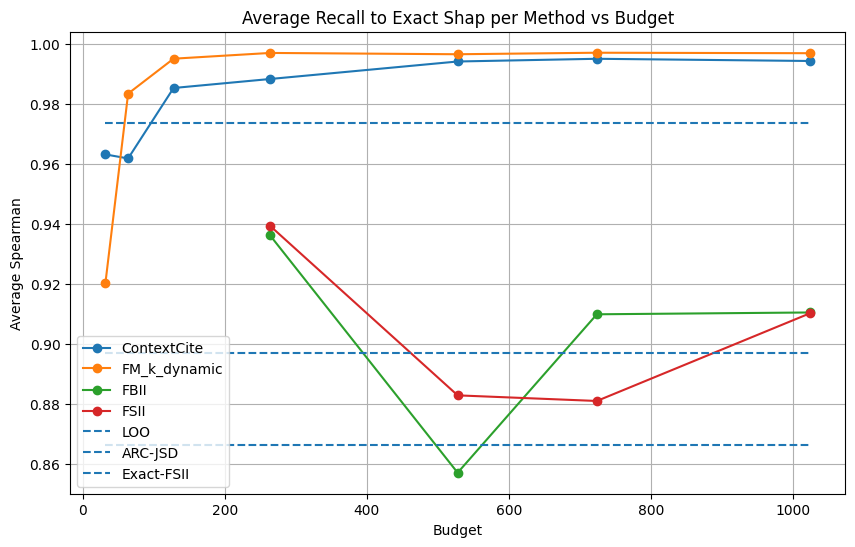

In [9]:
import re
import numpy as np
import matplotlib.pyplot as plt

# Parse methods and budgets
parsed = {}
budgets = set()
for key, values in spearmans.items():
    avg_val = np.mean(values)
    
    match = re.match(r"(.+?)_(\d+)$", key)  # method_budget pattern
    if match:
        method, budget = match.groups()
        budget = int(budget)
        budgets.add(budget)
        parsed.setdefault(method, {})[budget] = avg_val
    else:
        # constant methods (no budget)
        parsed.setdefault(key, {})[None] = avg_val

budgets = sorted(budgets)

# Plot
plt.figure(figsize=(10,6))

for method, results in parsed.items():
    if None in results:  # constant method
        plt.hlines(results[None], xmin=min(budgets), xmax=max(budgets), 
                   linestyles='--', label=method)
    else:
        xs = sorted(results.keys())
        ys = [results[b] for b in xs]
        plt.plot(xs, ys, marker='o', label=method)

plt.xlabel("Budget")
plt.ylabel("Average Spearman")
plt.title("Average Recall to Exact Shap per Method vs Budget")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
all_results[1]

In [10]:
import pandas as pd
import numpy as np
from collections import defaultdict

def summarize_and_print(all_results, k_values=[1, 2, 3,4,5]):
    table_data = defaultdict(lambda: defaultdict(list))

    # Mapping for consistency
    method_name_map = {
        
    }

    for res in all_results:
        metrics = res["metrics"]


        # LDS and R2
        for method_name, lds_val in metrics["LDS"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["LDS"].append(lds_val)

        for method_name, lds_val in metrics["R2"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["R2"].append(lds_val)
        # Top-k
        for method_name, k_dict in metrics["topk_probability"].items():
            method = method_name_map.get(method_name, method_name)
            for k in k_values:
                if k in k_dict:
                    col_name = f"topk_probability_k{k}"
                    table_data[method][col_name].append(k_dict[k])
        
        for method_name, k_dict in metrics["Recall"].items():
            method = method_name_map.get(method_name, method_name)
            for k in k_values:
                col_name = f"Recall@{k}"
                table_data[method][col_name].append(k_dict[k-1])
    # Averages
    avg_table = {
        method: {metric: np.nanmean(values) for metric, values in metric_dict.items()}
        for method, metric_dict in table_data.items()
    }

    # Standard deviations for LDS, R², and MSE
    for method, metric_dict in table_data.items():
        for metric in ["LDS", "R2"]:
            if metric in metric_dict:
                avg_table[method][f"{metric}_std"] = np.nanstd(metric_dict[metric])

    df_summary = pd.DataFrame.from_dict(avg_table, orient="index").sort_index()

    print("\n=== Metrics Summary Across All Queries ===")
    print(df_summary.to_string(float_format="%.4f"))

    return df_summary
df_res=summarize_and_print(all_results, k_values=[1, 2, 3,4,5])



=== Metrics Summary Across All Queries ===
                     LDS      R2  topk_probability_k1  topk_probability_k2  topk_probability_k3  topk_probability_k4  topk_probability_k5  Recall@1  Recall@2  Recall@3  Recall@4  Recall@5  LDS_std  R2_std
ARC-JSD           0.7566 -0.7702               8.3025               8.3259               9.6078              11.0617              11.2525    0.2976    0.5119    0.6905    0.8214    0.8571   0.1201  0.7317
ContextCite_1024  0.8536  0.7557               8.0347              10.5519              13.0866              13.4526              13.6826    0.3095    0.6310    0.9167    0.9405    0.9524   0.0522  0.1220
ContextCite_128   0.8414  0.7415               8.0347              10.4852              12.7430              13.1086              13.5663    0.3095    0.6190    0.8571    0.9048    0.9405   0.0564  0.1302
ContextCite_264   0.8457  0.7473               8.0347              10.5531              12.8210              13.2792              13.555

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Separate constant methods (no budget) and budgeted methods
constant_methods = ['LOO', 'ARC-JSD', 'Exact-FSII', 'Exact-Shap']
df_const = df_reset[df_reset['method'].isin(constant_methods)]
df_budgeted = df_reset[~df_reset['method'].isin(constant_methods)]

# Extract family and budget for budgeted methods
df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))
df_budgeted = df_budgeted.sort_values(by=['family', 'budget'])

# Function to plot metric
def plot_metric(metric, ylabel):
    plt.figure(figsize=(12, 6))

    # Plot budgeted families
    families = df_budgeted['family'].unique()
    for fam in families:
        if 'LK' not in fam and "Wei" not in method:
            subset = df_budgeted[df_budgeted['family'] == fam]
            plt.plot(subset['budget'], subset[metric], marker='o', label=fam)

    # Plot constant methods as horizontal lines
    colors = plt.cm.tab10.colors  # categorical palette
    for idx, (_, row) in enumerate(df_const.iterrows()):
        plt.axhline(y=row[metric], color=colors[idx % len(colors)],marker='x', label=row['method'])

    plt.xlabel("Budget")
    plt.ylabel(ylabel)
    plt.title(f"Evolution of {ylabel} with Increasing Budget")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot LDS
# plot_metric("LDS", "LDS")

# Plot R²
# plot_metric("R2", "R²")

# plot_metric("Recall@1", "Recall 1")
# plot_metric("Recall@2", "Recall 2")
# plot_metric("Recall@3", "Recall 3")
# plot_metric("Recall@4", "Recall 4")
# plot_metric("Recall@5", "Recall 5")


/tmp/ipykernel_615014/2905604916.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
/tmp/ipykernel_615014/2905604916.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))


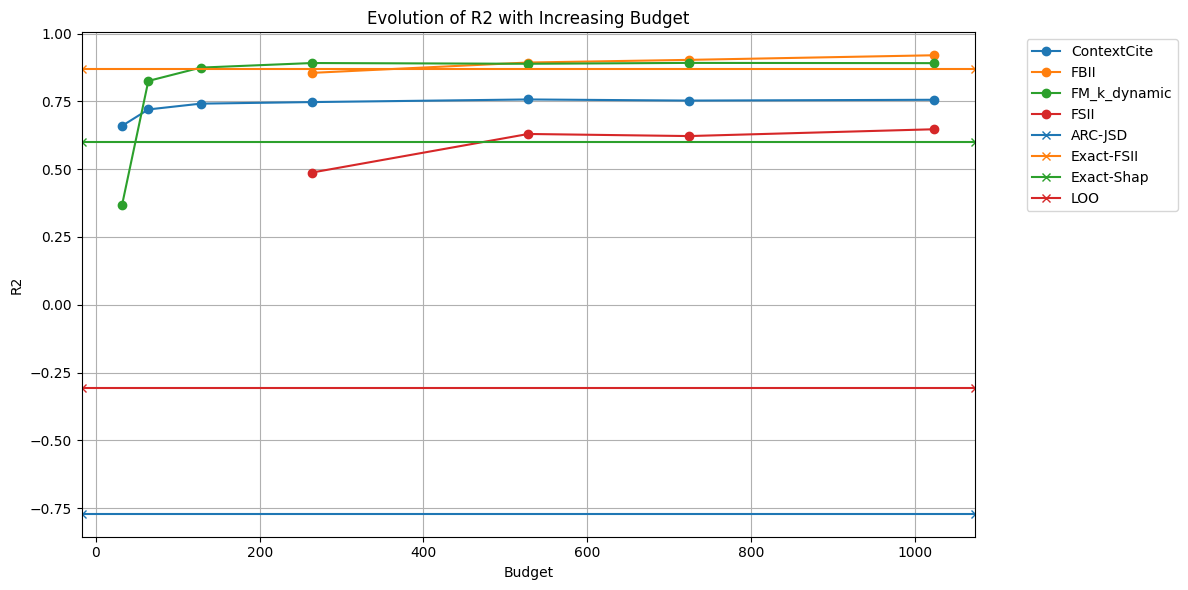

In [12]:
plot_metric("R2", "R2")

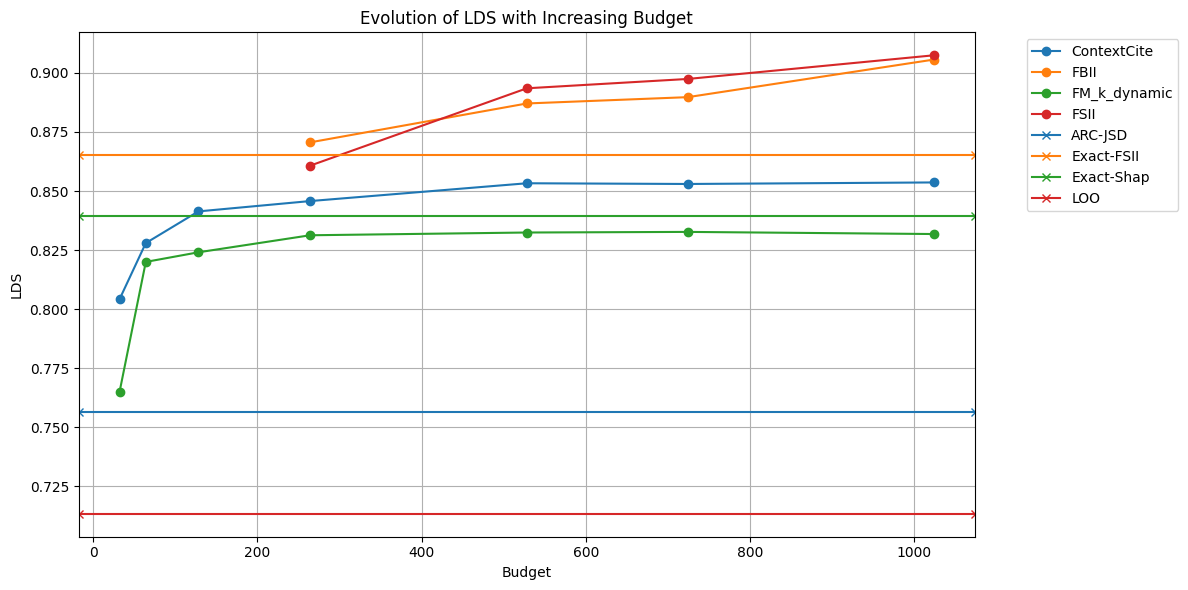

In [13]:
plot_metric("LDS", "LDS")

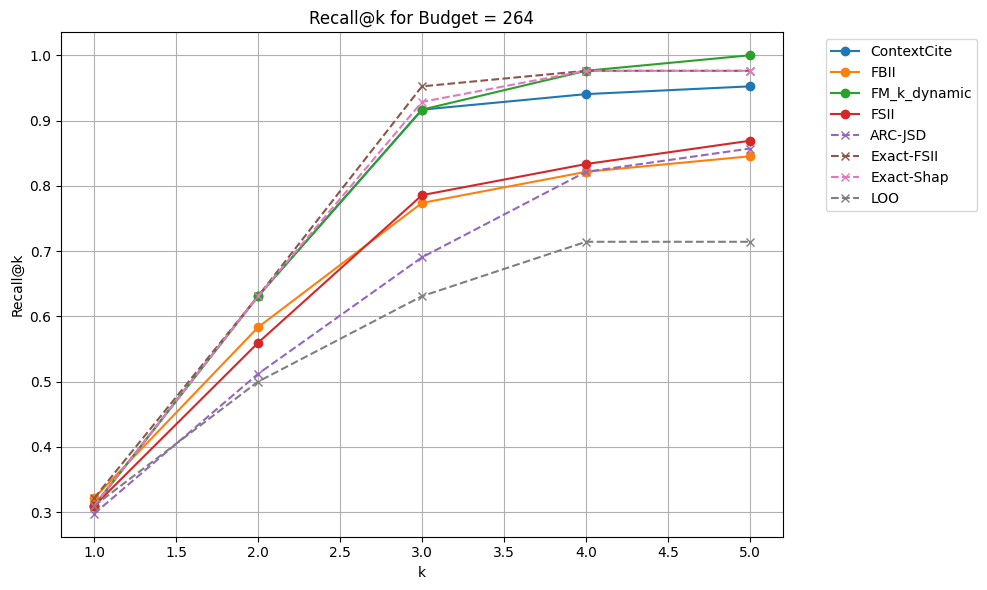

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter budgeted methods at budget = 274
df_budgeted_264 = df_budgeted[df_budgeted['budget'] == 1024]

# Metrics to plot
recall_metrics = [f"Recall@{k}" for k in range(1, 6)]
k_values = list(range(1, 6))

plt.figure(figsize=(10, 6))

# Plot budgeted families at budget 274
families = df_budgeted_264['family'].unique()
for fam in families:
    if 'LK' not in fam:
        subset = df_budgeted_264[df_budgeted_264['family'] == fam]
        if not subset.empty:
            recalls = subset[recall_metrics].values.flatten()
            plt.plot(k_values, recalls, marker='o', label=fam)

# Plot constant methods
for idx, (_, row) in enumerate(df_const.iterrows()):
    recalls = [row[m] for m in recall_metrics]
    plt.plot(k_values, recalls, marker='x', linestyle="--", label=row['method'])

plt.xlabel("k")
plt.ylabel("Recall@k")
plt.title("Recall@k for Budget = 264")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_615014/1503898388.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(df_nonfm['method'].unique()))


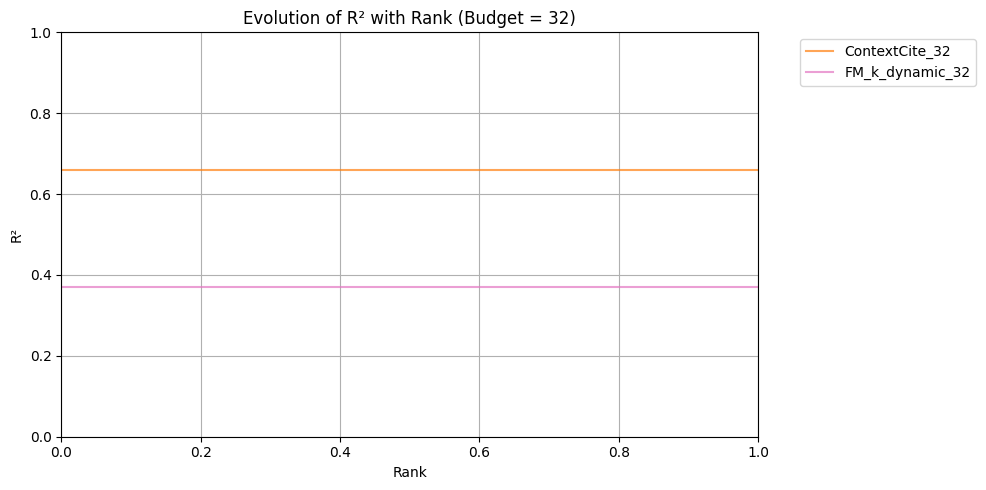

/tmp/ipykernel_615014/1503898388.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(df_nonfm['method'].unique()))


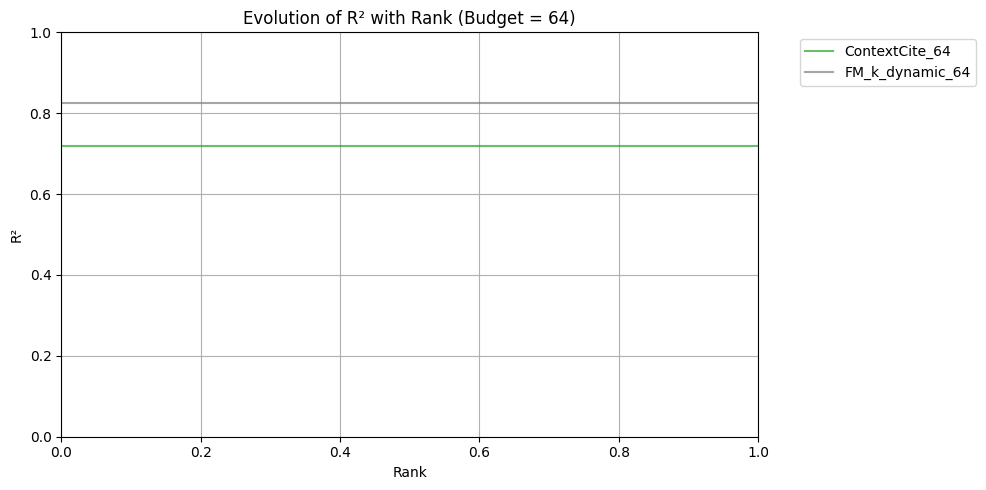

/tmp/ipykernel_615014/1503898388.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(df_nonfm['method'].unique()))


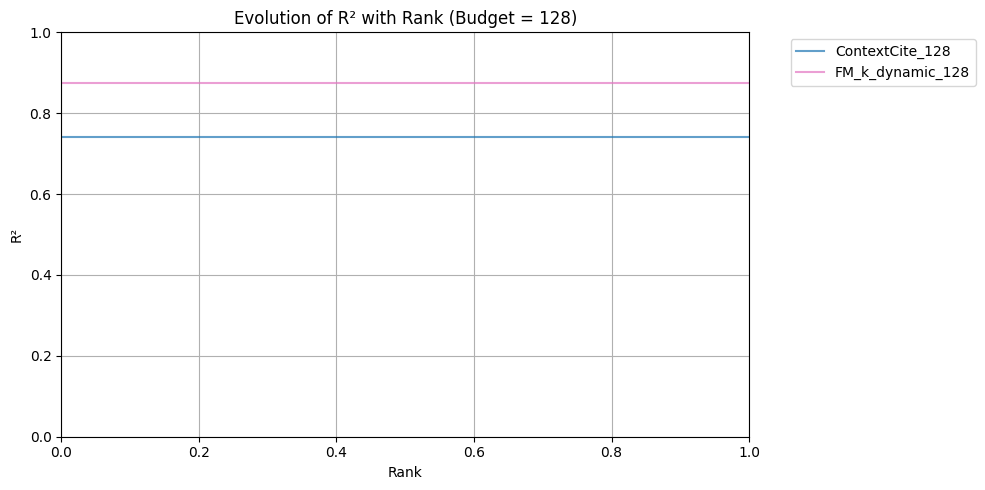

/tmp/ipykernel_615014/1503898388.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(df_nonfm['method'].unique()))


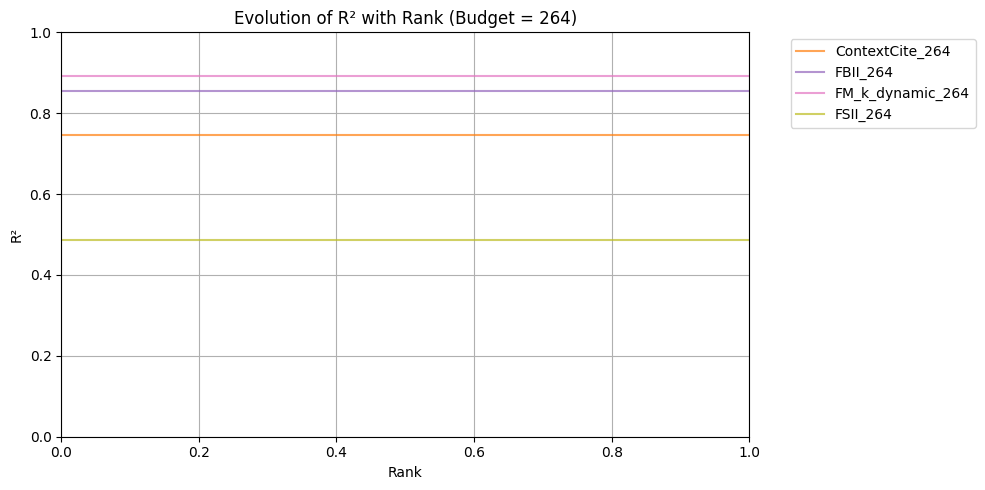

/tmp/ipykernel_615014/1503898388.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(df_nonfm['method'].unique()))


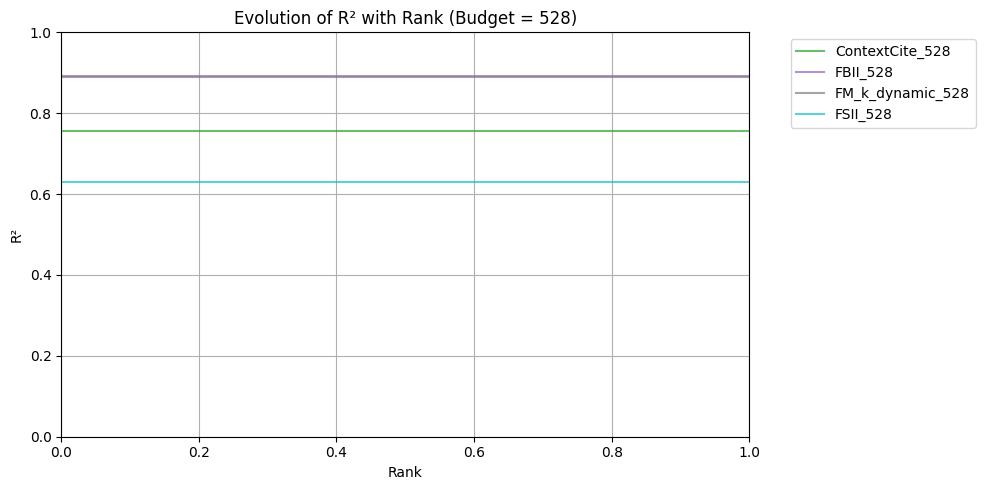

/tmp/ipykernel_615014/1503898388.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(df_nonfm['method'].unique()))


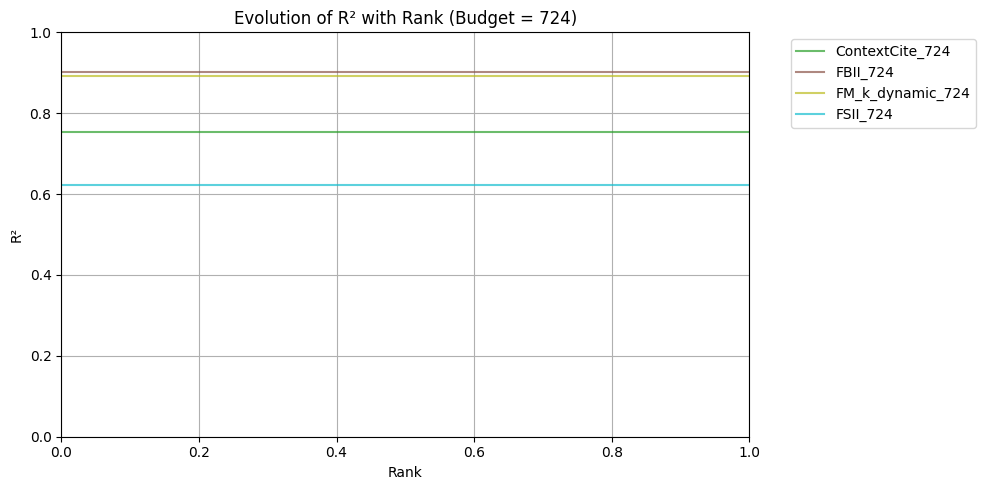

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Parse FM methods (rank + budget)
def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and parts[1].startswith("Weights"):
        # Example: FM_WeightsLU_5_32 → parts = ['FM', 'WeightsLU', '5', '32']
        variant = parts[1]        # 'WeightsLU' or 'WeightsLK'
        rank = int(parts[2])
        budget = int(parts[-1])
        return f"{parts[0]}_{variant}", rank, budget
    return None, None, None

df_reset[["family", "rank", "budget"]] = pd.DataFrame(
    df_reset["method"].apply(parse_fm).tolist(),
    index=df_reset.index
)
# Separate FM and non-FM methods
df_fm = df_reset[df_reset['family'].notnull()]
df_nonfm = df_reset[df_reset['family'].isnull()]

# Keep only ContextCite baselines
# df_rest = df_nonfm[df_nonfm['method'].str.startswith("ContextCite")]

# Function to plot R² for a given budget
def plot_r2_for_budget(budget):
    plt.figure(figsize=(10, 5))

    for family, subset in df_fm[df_fm['budget'] == budget].groupby("family"):
        subset = subset.sort_values(by="rank")
        plt.plot(subset["rank"], subset["R2"], marker='o', label=f"{family} (R²)")

    cmap = plt.cm.get_cmap("tab10", len(df_nonfm['method'].unique()))

    # Assign each unique method a color
    method_to_color = {
        method: cmap(i) for i, method in enumerate(df_nonfm['method'].unique())
    }

    # Plot
    for _, row in df_nonfm.iterrows():
        if row['method'].endswith(f"_{budget}"):
            plt.axhline(
                y=row['R2'],
                alpha=0.7,
                label=row['method'],
                color=method_to_color[row['method']]
            )

    plt.xlabel("Rank")
    plt.ylabel("R²")
    plt.title(f"Evolution of R² with Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot for budget = 528
plot_r2_for_budget(32)
plot_r2_for_budget(64)
plot_r2_for_budget(128)
plot_r2_for_budget(264)
plot_r2_for_budget(528)
plot_r2_for_budget(724)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Parse FM methods (rank + budget)
def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and parts[1].startswith("Weights"):
        # Example: FM_WeightsLU_5_32 → parts = ['FM', 'WeightsLU', '5', '32']
        variant = parts[1]        # 'WeightsLU' or 'WeightsLK'
        rank = int(parts[2])
        budget = int(parts[-1])
        return f"{parts[0]}_{variant}", rank, budget
    return None, None, None

df_reset[["family", "rank", "budget"]] = pd.DataFrame(
    df_reset["method"].apply(parse_fm).tolist(),
    index=df_reset.index
)
# Separate FM and non-FM methods
df_fm = df_reset[df_reset['family'].notnull()]
df_nonfm = df_reset[df_reset['family'].isnull()]

# Keep only ContextCite baselines
df_contextcite = df_nonfm[df_nonfm['method'].str.startswith("ContextCite")]
df_exact = df_nonfm[df_nonfm['method'].str.startswith("Exact")]

# Function to plot R² for a given budget
def plot_r2_for_budget(budget):
    plt.figure(figsize=(10, 5))

    for family, subset in df_fm[df_fm['budget'] == budget].groupby("family"):
        subset = subset.sort_values(by="rank")
        plt.plot(subset["rank"], subset["LDS"], marker='o', label=f"{family} (LDS)")

    cmap = plt.cm.get_cmap("tab10", len(df_nonfm['method'].unique()))

    # Assign each unique method a color
    method_to_color = {
        method: cmap(i) for i, method in enumerate(df_nonfm['method'].unique())
    }

    # Plot
    for _, row in df_nonfm.iterrows():
        if row['method'].endswith(f"_{budget}"):
            plt.axhline(
                y=row['LDS'],
                alpha=0.7,
                label=row['method'],
                color=method_to_color[row['method']]
            )

    plt.xlabel("Rank")
    plt.ylabel("LDS")
    plt.title(f"Evolution of LDS with Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot for budget = 528
plot_r2_for_budget(32)
plot_r2_for_budget(64)
plot_r2_for_budget(128)
plot_r2_for_budget(264)
plot_r2_for_budget(528)
plot_r2_for_budget(724)
plot_r2_for_budget(1024)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index and parse FM methods
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and parts[1].startswith("Weights"):
        variant = parts[1]
        rank = int(parts[2])
        budget = int(parts[-1])
        return f"{parts[0]}_{variant}", rank, budget
    return None, None, None

df_reset[["family", "rank", "budget"]] = pd.DataFrame(
    df_reset["method"].apply(parse_fm).tolist(),
    index=df_reset.index
)

df_fm = df_reset[df_reset['family'].notnull()]
df_nonfm = df_reset[df_reset['family'].isnull()]

# 🔹 Create a global color map for ALL methods (FM + non-FM)
all_labels = list(df_fm['family'].unique()) + list(df_nonfm['method'].unique())
palette = sns.color_palette("tab20", len(all_labels))
color_map = dict(zip(all_labels, palette))

# 🔹 Function to plot topk_probability_k3 vs Rank for a given budget
def plot_topk_for_budget(budget):
    plt.figure(figsize=(10, 5))

    # Plot FM methods (ranked)
    for family, subset in df_fm[df_fm['budget'] == budget].groupby("family"):
        subset = subset.sort_values(by="rank")
        plt.plot(
            subset["rank"],
            subset["topk_probability_k3"],
            marker='o',
            label=family,
            color=color_map[family]
        )

    # Plot non-FM methods (horizontal lines)
    for _, row in df_nonfm.iterrows():
        if row['method'].endswith(f"_{budget}") or row['method'] in ["Exact-FSII"]:
            plt.axhline(
                y=row['topk_probability_k3'],
                linestyle='--',
                color=color_map[row['method']],
                alpha=0.8,
                label=row['method']
            )

    plt.xlabel("Rank (only for FM)")
    plt.ylabel("Top-k Probability (k=3)")
    plt.title(f"topk_probability_k3 vs Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example: plot for budget = 528
plot_topk_for_budget(32)
plot_topk_for_budget(64)
plot_topk_for_budget(128)
plot_topk_for_budget(264)
plot_topk_for_budget(528)
plot_topk_for_budget(724)
plot_topk_for_budget(1024)


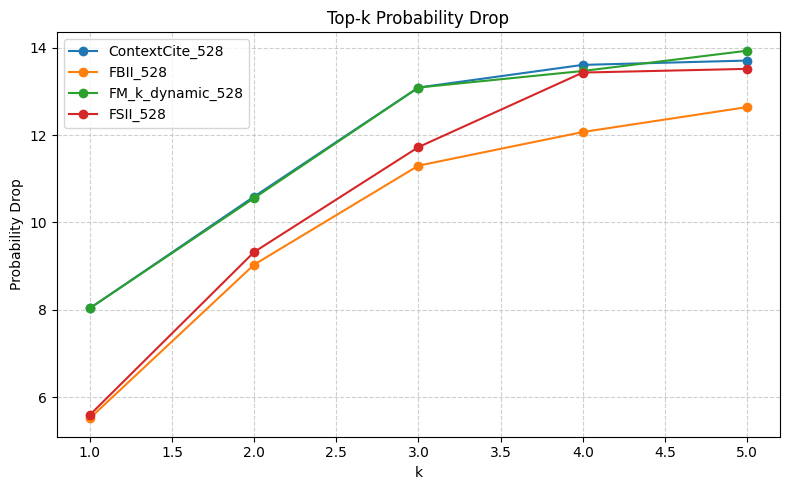

In [16]:
plt.figure(figsize=(8, 5))
for method in df_res.index:
    if "528" in method and "Wei" not in method:
        plt.plot(
            [1, 2, 3,4,5],
            df_res.loc[method, ['topk_probability_k1', 'topk_probability_k2', 'topk_probability_k3', 'topk_probability_k4', 'topk_probability_k5']],
            marker='o',
            label=method
        )

plt.xlabel('k')
plt.ylabel('Probability Drop')
plt.title('Top-k Probability Drop')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
extras[2].keys()

In [17]:
import numpy as np

def evaluate_methods(extras, k, m, interaction_type="max"):

    methods = extras[0].keys()
    scores = {m: 0 for m in methods}
    n_experiments = len(extras)

    for exp in extras:
        for method in methods:
            if "Fl" in method or "FM" in method:
                # Flu is a matrix
                value = exp[method][k][m]
                all_values = exp[method].flatten()
            else:
                # Dictionaries with tuple keys
                d = exp[method]
                value = None
                for key, v in d.items():
                    if key == (k, m):
                        value = v
                        break
                if value is None:
                    continue  # skip if (k,m) not found
                all_values = list(d.values())

            if interaction_type == "max":
                if value == max(all_values):
                    scores[method] += 1
            elif interaction_type == "min":
                if value == min(all_values):
                    scores[method] += 1

    # Convert to fraction of experiments
    results = {method: scores[method] / n_experiments for method in methods}
    return results

# Second stage

In [18]:
# Recovery rate
rr={}
for i, j in enumerate(np.array(list(evaluate_methods(extras, k=0, m=1, interaction_type="max").values()))+np.array(list(evaluate_methods(extras, k=0, m=5, interaction_type="max").values()))+np.array(list(evaluate_methods(extras, k=1, m=5, interaction_type="min").values()))):
    rr.update({list(extras[0].keys())[i]:j})

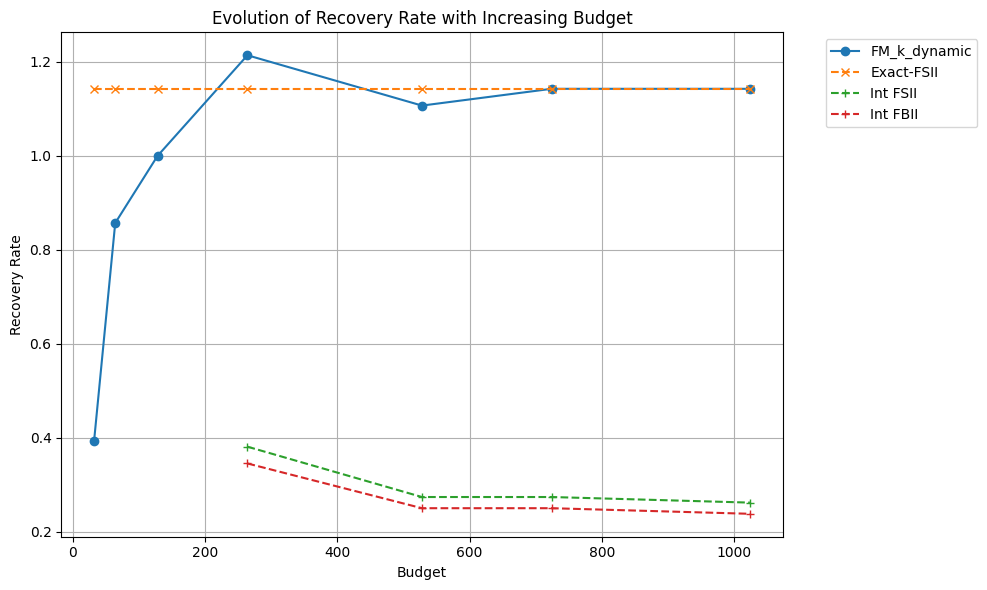

In [27]:
rows = []
for k, v in rr.items():
    parts = k.split("_")
    if parts[0] == "Flu" and parts[1]!='0':
        _, rank, budget = parts
        rows.append({"method": "Flu", "rank": int(rank), "budget": int(budget), "recovery": v})
    elif parts[0] == "FM"and parts[3]!='0':
        _,_,_,budget = parts
        rows.append({"method": f'FM_k_dynamic', "budget": int(budget), "recovery": v})
    elif parts[0] == "Int":
        _, name, budget = parts
        rows.append({"method": name, "budget": int(budget), "recovery": v})

df = pd.DataFrame(rows)

# Plot
plt.figure(figsize=(10, 6))

# Plot Flu (different ranks as lines)
# for rank in sorted(df[df["method"]=="Flu"]["rank"].unique()):
#     sub = df[(df["method"]=="Flu") & (df["rank"]==rank)].sort_values("budget")
#     plt.plot(sub["budget"], sub["recovery"]/3, marker="o", label=f"Flu rank {rank}")

# for rank in sorted(df[df["method"]=="FM_k_dynamic"]["rank"].unique()):
#     sub = df[(df["method"]=="FM_k_dynamic") & (df["rank"]==rank)].sort_values("budget")
#     plt.plot(sub["budget"], sub["recovery"]/3, marker="o", label=f"FM_k_dynamic rank {rank}")
# for rank in sorted(df[df["method"]=="FM_r_dynamic"]):
sub1 = df[(df["method"]=="FM_k_dynamic")].sort_values("budget")
plt.plot(sub1["budget"], sub1["recovery"], marker="o", label=f"FM_k_dynamic")
plt.plot(sub1["budget"],rr['Exact-FSII']*np.ones(7), marker="x", linestyle="--", label=f"Exact-FSII")

# Plot Int methods (evolve with budget, start at 264)
for m in df[df["method"].isin(["FSII","FBII","Spex"])]['method'].unique():
    sub = df[df["method"]==m].sort_values("budget")
    plt.plot(sub["budget"], sub["recovery"]/3, marker="+", linestyle="--", label=f"Int {m}")



plt.xlabel("Budget")
plt.ylabel("Recovery Rate")
plt.title("Evolution of Recovery Rate with Increasing Budget")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
extras[1].keys()

In [ ]:
1. compare the new and old fm
2. iteration with the interactions
3. shapley is for first order and faithshap for pairwise

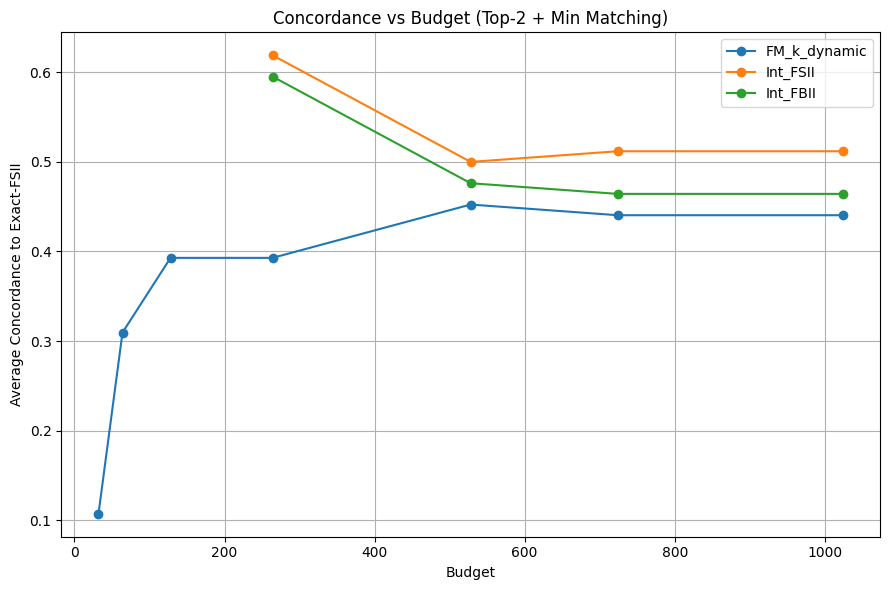

In [22]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def get_top2_min_from_dict(d):
    """Return top-2 and min interaction pairs from a dict {(i, j): val}."""
    if not d:
        return set(), None
    sorted_items = sorted(d.items(), key=lambda x: x[1], reverse=True)
    top2 = {sorted_items[0][0], sorted_items[1][0]} if len(sorted_items) >= 2 else {sorted_items[0][0]}
    min_pair = min(d.items(), key=lambda x: x[1])[0]
    return top2, min_pair

def get_top2_min_from_matrix(mat):
    """Return top-2 and min interaction pairs from a numpy or list matrix."""
    mat = np.array(mat)
    pairs = {(i, j): mat[i][j] for i in range(mat.shape[0]) for j in range(mat.shape[1]) if i != j}
    return get_top2_min_from_dict(pairs)

def extract_budget(key):
    match = re.search(r'_(\d+)$', key)
    return int(match.group(1)) if match else None

def extract_family(key):

    if key.startswith("Flu_"):
        # e.g. Flu_5_128 → Flu_5
        m = re.match(r"(Flu_\d+)_\d+", key)
        return m.group(1) if m else None
    elif key.startswith("FM_k_dynamic"):
        return "FM_k_dynamic"
    elif key.startswith("Int_FSII"):
        return "Int_FSII"
    elif key.startswith("Int_FBII"):
        return "Int_FBII"
    return None

def compare_methods_concordance(extras):
    concordance = defaultdict(list)

    for d in extras:
        exact = d.get('Exact-FSII', {})
        exact_top2, exact_min = get_top2_min_from_dict(exact)

        for key, val in d.items():
            if key == 'Exact-FSII':
                continue

            try:
                if isinstance(val, dict):
                    top2, min_pair = get_top2_min_from_dict(val)
                else:
                    top2, min_pair = get_top2_min_from_matrix(val)
            except Exception:
                continue

            matches = len(exact_top2.intersection(top2))
            if exact_min == min_pair:
                matches += 1

            score = matches / 3
            concordance[key].append(score)

    avg_concordance = {k: np.mean(v) for k, v in concordance.items() if v}
    return avg_concordance

def group_by_family_and_budget(avg_concordance):
    grouped = defaultdict(list)
    for key, score in avg_concordance.items():
        budget = extract_budget(key)
        family = extract_family(key)
        if family and budget:
            grouped[family].append((budget, score))

    # Sort budgets
    for family in grouped:
        grouped[family].sort(key=lambda x: x[0])
    return grouped

def plot_concordance(grouped):
    plt.figure(figsize=(9,6))
    for family, data in grouped.items():
        budgets, scores = zip(*data)
        plt.plot(budgets, scores, marker='o', label=family)

    plt.xlabel("Budget")
    plt.ylabel("Average Concordance to Exact-FSII")
    plt.title("Concordance vs Budget (Top-2 + Min Matching)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

avg_concordance = compare_methods_concordance(extras)
grouped = group_by_family_and_budget(avg_concordance)
plot_concordance(grouped)
